# Figure 11: MHC diversity vs cancer risk

# Set up

In [1]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import statsmodels.api as sm

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# get current date 
timestr = time.strftime("%Y%m%d") 

In [3]:
# specify font size for plotting 
plt.rcParams.update({'font.sans-serif':'Verdana'})

# Load datasets

## MHC genotype (UKBB)

In [4]:

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df_hla = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df_hla.columns = head 
print("Number of samples with genotype data:", df_hla.shape[0])

# QUALITY CONTROL (check how genotyping went)
# count in how many cases we're not sure on the allele genotype
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df_hla.filter(regex='^(Person_|D)') # 488377 cases 

df_hla1_count_05 = df_hla1.values.flatten().tolist().count(0.5)
df_hla1_count_15 = df_hla1.values.flatten().tolist().count(1.5)

df_hla2_count_05 = df_hla2.values.flatten().tolist().count(0.5)
df_hla2_count_15 = df_hla2.values.flatten().tolist().count(1.5)

print('Number of 0.5 typing for HLA class I:', df_hla1_count_05)
print('Number of 1.5 typing for HLA class I:', df_hla1_count_15)
print('Number of 0.5 typing for HLA class II:', df_hla2_count_05)
print('Number of 1.5 typing for HLA class II:', df_hla2_count_15)

# SELECT MHC CLASS I and CLASS II
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df_hla.filter(regex='^(Person_|D)') # 488377 cases 

# FILTERING (separately for MHC class I and MHC class II)
# filtering wise: exclude individuals with 0.5 genotype
# if someone is genotyped as 1.5, change to 2 
# this is the filtering used in https://www.science.org/doi/10.1126/science.adi3808, I think it makes sense so I will stick with this 
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lack a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lack a genotype

df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lack a genotype
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lack a genotype

# SPLIT MHC class II into DRB / DP / DQ
df_hla2_dp = df_clean_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_clean_hla2.filter(regex='^(Person_|DQ)')
df_hla2_dr = df_clean_hla2.filter(regex='^(Person_|DR)')

# obtain lists of Pariticipant IDs with correctly typed MHC data
ids_mhc1 = df_clean_hla1.Person_ID.unique()
ids_mhc2 = df_clean_hla2.Person_ID.unique()
ids_mhc1_mhc2 = set(ids_mhc1).intersection(set(ids_mhc2)) # intersection 

print("Number of samples which were correctly genotyped for MHC class I:", len(ids_mhc1))
print("Number of samples which were correctly genotyped for MHC class II:", len(ids_mhc2))
print("Number of samples which were correctly genotyped for MHC class I and class II:", len(ids_mhc1_mhc2))

# NOTE
# Because there is a different number of people with correctly typed MHC class I vs class II alleles
# I will first analyse these separately and then will do analysis of MHC class I + class II on these who only have both class I and class II correct 
# I want to run stuff separately to not lose valuable data ofc 

Number of samples with genotype data: 488377
Number of 0.5 typing for HLA class I: 45538
Number of 1.5 typing for HLA class I: 2565
Number of 0.5 typing for HLA class II: 106986
Number of 1.5 typing for HLA class II: 25163
Number of samples which were correctly genotyped for MHC class I: 443620
Number of samples which were correctly genotyped for MHC class II: 378317
Number of samples which were correctly genotyped for MHC class I and class II: 346968


# Heterozygosity status

In [5]:

# add columns to indicate heterozygosity status 

# HLA_classI_A, HLA_classI_B, HLA_classI_C, HLA_classII_DRB, HLA_classII_DPA, HLA_classII_DPB, HLA_classII_DQA, HLA_classII_DQB, total_het_I, total_het_II, total_het 

# define a function to get names of columns which indicate alleles present in the sample 
def get_columns_with_values(row, subset_columns):
    return [col for col in subset_columns if row[col] > 0]
    

In [6]:

# apply function to class I alleles

# reminder: filtered data to use: df_clean_hla1, df_clean_hla2

# filter columns with MHC class I alleles (start with A_, B_, C_)
subset_A = [col for col in df_clean_hla1.columns if col.startswith(('A_'))]
subset_B = [col for col in df_clean_hla1.columns if col.startswith(('B_'))]
subset_C = [col for col in df_clean_hla1.columns if col.startswith(('C_'))]

subsets_1 = [subset_A, subset_B, subset_C]

for subset in subsets_1:
    
    new_column_name = 'allele_I_' + subset[0][0] # the first letter will indicate class
    df_clean_hla1[new_column_name] = df_clean_hla1.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_clean_hla1.head(n = 5)

,Person_ID,A_101,A_102,A_103,A_201,A_202,A_203,A_205,A_206,A_207,...,C_1504,C_1505,C_1601,C_1602,C_1604,C_1701,C_1801,allele_I_A,allele_I_B,allele_I_C
0,2812213,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_201,"B_4001, B_4402","C_304, C_501"
1,4860169,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_101,"B_801, B_5701","C_602, C_701"
2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"A_2301, A_2402","B_1801, B_5701","C_501, C_602"
3,2805252,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_101,"B_702, B_5701","C_602, C_702"
4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"A_201, A_1101","B_5501, B_5701","C_303, C_602"


In [7]:

# apply function to class II alleles

subset_DR = [col for col in df_clean_hla2.columns if 'DRB1' in col] # this is the only one we want to look at at the moment 
subset_DPA = [col for col in df_clean_hla2.columns if 'DPA' in col]
subset_DPB = [col for col in df_clean_hla2.columns if 'DPB' in col]
subset_DQA = [col for col in df_clean_hla2.columns if 'DQA' in col]
subset_DQB = [col for col in df_clean_hla2.columns if 'DQB' in col]

subsets_2 = [subset_DR, subset_DPA, subset_DPB, subset_DQA, subset_DQB]

for subset in subsets_2:
    
    new_column_name = 'allele_II_' + subset[0][:3] # the first three letters indicate class
    df_clean_hla2[new_column_name] = df_clean_hla2.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_clean_hla2.head(n = 5)

,Person_ID,DRB5_101,DRB5_102,DRB5_202,DRB5_9901,DRB4_101,DRB4_103,DRB4_9901,DRB3_101,DRB3_202,...,DPA1_107,DPA1_201,DPA1_202,DPA1_301,DPA1_401,allele_II_DRB,allele_II_DPA,allele_II_DPB,allele_II_DQA,allele_II_DQB
1,4860169,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"DRB1_301, DRB1_1501",DPA1_103,"DPB1_301, DPB1_401","DQA1_102, DQA1_501","DQB1_201, DQB1_602"
2,3381323,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"DRB1_101, DRB1_401",DPA1_103,"DPB1_201, DPB1_401","DQA1_101, DQA1_301","DQB1_302, DQB1_501"
3,2805252,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,"DRB1_401, DRB1_1501","DPA1_103, DPA1_202","DPB1_101, DPB1_401","DQA1_102, DQA1_301","DQB1_301, DQB1_602"
5,3318036,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,DRB1_701,DPA1_201,DPB1_1101,DQA1_201,DQB1_202
6,4120291,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,"DRB1_103, DRB1_701",DPA1_201,"DPB1_1001, DPB1_1101","DQA1_101, DQA1_201","DQB1_202, DQB1_501"


In [8]:

# define a function to check if someone is heterozygous for a given class of alleles 
def is_heterozygous_allele(row, col):

    # count the number of alleles someone has 
    # count the number of commas + add 1 = number of entires
    count = row[col].count(',') + 1  
    
    # determine if they are heterozygous or homozygous 
    if count == 2:
        return True # has two alleles so heterozygous
    elif count == 1:
        return False # has 1 alleles so homozygous
    else:
        return None # we definitely should not have anything else !!! so return None and see in how many cases this happens

In [9]:
# list of columns we want to look at to determine heterozygosity status
columns_hla1 = ['allele_I_A', 'allele_I_B', 'allele_I_C']
columns_hla2 = ['allele_II_DRB', 'allele_II_DPA', 'allele_II_DPB', 'allele_II_DQA', 'allele_II_DQB']

for col in columns_hla1:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_clean_hla1[new_column_name] = df_clean_hla1.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

for col in columns_hla2:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_clean_hla2[new_column_name] = df_clean_hla2.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

In [10]:

# add total heterozygosity 
subset_classI = [col for col in df_clean_hla1.columns if col.startswith(('A_', 'B_', 'C_'))] # all class I alleles 
subset_classII = [col for col in df_clean_hla2.columns if col.startswith(('D'))] # all class II alleles 

# determine the number of unique alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the count is 3)
df_clean_hla1['count_class_I'] = df_clean_hla1[subset_classI].gt(0).sum(axis=1)
df_clean_hla2['count_class_II'] = df_clean_hla2[subset_classII].gt(0).sum(axis=1)

# this is so we get only counts for the 10 alleles we are looking at
subset_classII_drb = [col for col in df_clean_hla2.columns if col.startswith('DRB1') or col.startswith('DP') or col.startswith(('DQ'))] # all class II alleles 
df_clean_hla2['count_class_II_drb'] = df_clean_hla2[subset_classII_drb].gt(0).sum(axis=1)

# determine the number of alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the sum is 6)
df_clean_hla1['sum_class_I'] = df_clean_hla1[subset_classI].sum(axis=1)
df_clean_hla2['sum_class_II'] = df_clean_hla2[subset_classII].sum(axis=1)

# note that some people may not have been fully genotyped > I guess we should think about what to do with these cases 
df_clean_hla1['het_all_class_I'] = (df_clean_hla1['count_class_I'] == 6) # we dropped people who did not have genotype data available so if they dont have 6 alleles they are homozygous by our definition
df_clean_hla2['het_all_class_II'] = (df_clean_hla2['count_class_II'] == 10) 

# one way to check for total heterozygosity is to see whether you have 'TRUE' in all fields (het_allele A, B, C / het allele DRB, DPA, DPB, DQA, DQB)
df_clean_hla1['het_all_class_I_from_allele'] = (df_clean_hla1['het_allele_I_A'] & df_clean_hla1['het_allele_I_B'] & df_clean_hla1['het_allele_I_C'])
df_clean_hla2['het_all_class_II_from_allele'] = (df_clean_hla2['het_allele_II_DRB'] & df_clean_hla2['het_allele_II_DPB'] &df_clean_hla2['het_allele_II_DPA'] & df_clean_hla2['het_allele_II_DQB'] & df_clean_hla2['het_allele_II_DQA'])


In [11]:

# subset the data to only include ID and sums of alleles 
selected_columns1 = [col for col in df_clean_hla1.columns if not col.startswith(('A_', 'B_', 'C_'))]
subset_df1 = df_clean_hla1[selected_columns1]

selected_columns2 = [col for col in df_clean_hla2.columns if not col.startswith(('D_'))]
subset_df2 = df_clean_hla2[selected_columns2]

cols1 = ['het_all_class_I_from_allele', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C'] 
cols2 = ['het_all_class_II_from_allele', 'het_allele_II_DRB', 'het_allele_II_DQB', 'het_allele_II_DQA', 'het_allele_II_DPB', 'het_allele_II_DPA']

labels1 = ['class I', 'class I A', 'class I B', 'class I C']
labels2 = ['class II', 'class II DRB1', 'class II DQB', 'class II DQA', 'class II DPB', 'class II DPA']

sum_het1 = [df_clean_hla1[col].sum() for col in cols1]
total1 = len(df_clean_hla1['Person_ID'].unique())
percent_het1 = [s / total1 * 100 for s in sum_het1]
percent_hom1 = [100 - p for p in percent_het1]

sum_het2 = [df_clean_hla2[col].sum() for col in cols2]
total2 = len(df_clean_hla2['Person_ID'].unique())
percent_het2 = [s / total2 * 100 for s in sum_het2]
percent_hom2 = [100 - p for p in percent_het2]


In [12]:
df_counts1 = df_clean_hla1.count_class_I.value_counts().reset_index()
df_counts2 = df_clean_hla2.count_class_II_drb.value_counts().reset_index().sort_values(by = 'count_class_II_drb')

# add percentage values
df_counts1['percent'] = df_counts1['count'] / df_counts1['count'].sum() * 100
df_counts2['percent'] = df_counts2['count'] / df_counts2['count'].sum() * 100

df_counts1 = df_counts1.sort_values(by = 'count_class_I', ascending = True).reset_index()
df_counts2 = df_counts2.sort_values(by = 'count_class_II_drb', ascending = True).reset_index()

# subset the dataset to only include alleles present, heterozygote status etc.
df_sub_hla1 = df_clean_hla1.drop(columns=df_clean_hla1.columns[df_clean_hla1.columns.str.startswith(('A_', 'B_', 'C_'))])


# Add phenotype + outcome data (cancer)

In [13]:

# load datasets with phenotypic data (dataset from Hamish McGregor, sent on 28/02/2024)

pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')
ancestry_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_iadmix_ancestry_props.csv')

# make sure we have consistent naming for Person_ID column 
pheno_df = pheno_df.rename(columns={'ID_v0': 'Person_ID'}) 
ancestry_df = ancestry_df.rename(columns={'ukbid': 'Person_ID'}) 

# clean up datasets: IDs < 0 participants resigned from the study 
pheno_df = pheno_df[pheno_df.Person_ID > 0] # only retain participants with IDs greater than 0
ancestry_df = ancestry_df[ancestry_df.Person_ID > 0] # only retain participants with IDs greater than 0

# check how many people you have the data for
ids_pheno_data = pheno_df.Person_ID.unique()
ids_ancestry_data = ancestry_df.Person_ID.unique()

print('Number of people with phenotypic data available:', len(ids_pheno_data))
print('Number of people with ancestry data available:', len(ids_ancestry_data))

# identify people for whom both are available
ids_pheno_ancestry = set(ids_pheno_data).intersection(set(ids_ancestry_data)) # intersection 
print('Number of people with phenotypic and ancestry data available:', len(ids_pheno_ancestry))

ids_pheno_ancestry_mhc = set(ids_pheno_ancestry).intersection(set(ids_mhc1_mhc2)) # intersection 
print('Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I and II:', len(ids_pheno_ancestry_mhc))


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/3526144958.py:3: DtypeWarning: Columns (62,78,79,87,93,94,101,104,105,106,219,221,242,247,248,249,256,259,260,265,268,361,363,387,388,393,397,398,405,408,471,472,473,474,483,484,485,486,495,496,497,498,500,501,506,507,512,513) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')


Number of people with phenotypic data available: 502368
Number of people with ancestry data available: 502603
Number of people with phenotypic and ancestry data available: 502366
Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I and II: 346796


In [14]:

# create ancestry main column
ancestry_df_main = ancestry_df[['Person_ID', 'iadmix_main_ancestry_v2']]

ancestry_df_main['iadmix_main_ancestry_v2'] = pd.Categorical(ancestry_df_main['iadmix_main_ancestry_v2']) 
admix_dummies = pd.get_dummies(ancestry_df_main['iadmix_main_ancestry_v2'])
admix_dummies = admix_dummies.astype(int)
admix_df = pd.concat([ancestry_df_main, admix_dummies], axis=1)
admix_df = admix_df.drop('iadmix_main_ancestry_v2', axis = 1)
admix_df

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/562714986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry_df_main['iadmix_main_ancestry_v2'] = pd.Categorical(ancestry_df_main['iadmix_main_ancestry_v2'])


,Person_ID,AFR,EAS,EUR,Mixed,SAS
13,1000017,0,0,1,0,0
14,1000025,0,0,1,0,0
15,1000038,0,0,1,0,0
16,1000042,0,0,1,0,0
17,1000056,0,0,1,0,0
...,...,...,...,...,...,...
502611,6026161,0,0,1,0,0
502612,6026174,0,0,1,0,0
502613,6026189,0,0,1,0,0
502614,6026193,0,0,1,0,0


## Cancer outcomes

In [15]:
# for phenotype, we will be looking at the first.diagnosed.cancer.type1 column
# this contains ICD-10 cancer codes 
# load the dataset with code descriptors
cancer_codes_desc = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/cancer_codes_desc.csv')
cancer_codes_desc

,ICD_code,description,classification
0,C00,oral cancer,head_and_neck
1,C01,oral cancer,head_and_neck
2,C02,oral cancer,head_and_neck
3,C03,oral cancer,head_and_neck
4,C04,oral cancer,head_and_neck
...,...,...,...
85,C94,leukemia,lymphatic_hematopoietic
86,C95,leukemia,lymphatic_hematopoietic
87,C96,non-Hodgkin lymphoma,lymphatic_hematopoietic
88,C97,unclassified,other


In [16]:

# what cancers to look at: get codes of cancers which are most common (top 25?)
cancer_counts = pheno_df['first.diagnosed.cancer.type1'].value_counts().reset_index() # counts of different cancer codes in the dataset 
cancer_counts.rename(columns = {'first.diagnosed.cancer.type1' : 'ICD_code'}, inplace = True)
cancer_counts_desc = pd.merge(cancer_counts,cancer_codes_desc, on = 'ICD_code')

# # identify cancers with > 1000 cases in the UKBB 
cancers_1000_cases = cancer_counts_desc[cancer_counts_desc['count'] >= 1000]
cancers_1000_cases_ids = cancers_1000_cases.ICD_code.tolist()

# identify top 25 most common cancers in the UKBB  
cancers_top25_cases = cancer_counts_desc.iloc[0:24]
cancers_top25_cases_ids = cancers_top25_cases.ICD_code.tolist()

# # save all counts data, can be useful to look at and compare to the actual name 
# pd.DataFrame(cancer_counts).to_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/cancer_counts_UKBB_diagnosed_histology1.csv')

In [22]:

# create outcome table 

# create a quick dataframe with Patient ID and cancer diagnosis (for 25 most common cancers + any cancer)
cancer_df = pheno_df[['Person_ID', 'first.diagnosed.cancer.type1']]

# change type of code to int > string
cancer_df['first.diagnosed.cancer.type1'] = cancer_df['first.diagnosed.cancer.type1'].astype(str)
cancer_df['first.diagnosed.cancer.type1'].unique()

# now we want to change it such that we have 25 columns with status for a specific cancer + any cancer (ie diangosed not NaN)
# this is quite a funky way of doing it but it work

# 1 if someone has cancer but 
for index, row in cancer_df.iterrows():
    if row['first.diagnosed.cancer.type1'] == 'nan': # do not change NaN values 
        continue
    if row['first.diagnosed.cancer.type1'] not in cancers_top25_cases_ids: # if has other cancer, change to 'other'
         cancer_df.at[index, 'first.diagnosed.cancer.type1'] = 'other'

# convert to categorical column
cancer_df['first.diagnosed.cancer.type1'] = pd.Categorical(cancer_df['first.diagnosed.cancer.type1']) 

# prepare 'dummies dataframe'
cancer_dummies = pd.get_dummies(cancer_df['first.diagnosed.cancer.type1'])

# add column 'has cancer 
cancer_dummies['has_cancer'] = cancer_dummies.iloc[:, -2].replace({True: 0, False: 1})
cancer_dummies = cancer_dummies.astype(int)

# create the complete dataframe 
cancer_df = pd.concat([cancer_df, cancer_dummies], axis=1)

# add age at first cancer diagnosis 
cancer_age_df = pheno_df[['Person_ID', 'first.diagnosed.cancer.type1']]
cancer_df = pd.merge(cancer_df, cancer_age_df, on = 'Person_ID')

# remove the column
cols_to_drop = ['first.diagnosed.cancer.type1_x', 'nan']
cols_to_retain = [x for x in cancer_df.columns.tolist() if x not in cols_to_drop]

# this is our dataframe with features (Age, Sex, Smoking, Ehtnic, BMI, Waist + cancer outcomes)
outcome_df = cancer_df[cols_to_retain]


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/3553479718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df['first.diagnosed.cancer.type1'] = cancer_df['first.diagnosed.cancer.type1'].astype(str)
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/3553479718.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df['first.diagnosed.cancer.type1'] = pd.Categorical(cancer_df['first.diagnosed.cancer.type1'])


# Dataframe with phenotype features 

In [23]:

# Select features of interest 

# FEATURES: Age, Sex_v0, Genetic.sex_v0, Ever.smoked_v0, Ethnic.background_v0, Body.maxx,index..BMI._v0, Waist.circumference_v1 

# create age column (age at attending assessment centre)
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Date.of.attending.assessment.centre_v0'].str.split('-').str[0] # determine year of attending assessment centre
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Year.of.birth_v0'] = pheno_df['Year.of.birth_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'] - pheno_df['Year.of.birth_v0'] # determine age when attended assessment centre
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Age.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 

# not sure where on Earth I would get the socio-economic index out from
features = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0','Ethnic.background_v0', 'Body.mass.index..BMI._v0', 'Waist.circumference_v1'] 
features_df = pheno_df[features]
features_df

,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Ethnic.background_v0,Body.mass.index..BMI._v0,Waist.circumference_v1
0,1000017,65.0,Female,Yes,British,26.9949,NaN
1,1000025,51.0,Female,Yes,British,22.5460,NaN
2,1000038,52.0,Female,No,British,31.5882,NaN
3,1000042,52.0,Male,No,British,29.3210,NaN
4,1000056,65.0,Female,No,British,27.1382,NaN
...,...,...,...,...,...,...,...
502363,6026189,66.0,Female,No,British,29.9548,NaN
502364,6026193,59.0,Female,No,British,30.4491,NaN
502365,6026206,NaN,Male,NaN,NaN,NaN,NaN
502366,6026214,NaN,Female,NaN,NaN,NaN,NaN


In [24]:

# format categorical features correctly

# for binary outcomes, convert to 0 / 1
features_df['Sex_v0'] = features_df['Sex_v0'].replace({'Female': 0, 'Male': 1})
features_df['Ever.smoked_v0'] = features_df['Ever.smoked_v0'].replace({'Yes': 1, 'No': 0})

# for categorical data with no 1 / 0 levels, need to create dummies again 
ethnic_df = features_df[['Person_ID', 'Ethnic.background_v0']]
ethnic_df['Ethnic.background_v0'] = pd.Categorical(ethnic_df['Ethnic.background_v0']) 
ethnic_dummies = pd.get_dummies(ethnic_df['Ethnic.background_v0'])
ethnic_dummies = ethnic_dummies.astype(int) # we want to convert True / False to 1 / 0
ethnic_dummies = ethnic_dummies.drop(['Do not know', 'Prefer not to answer'], axis = 1)
features_df = pd.concat([features_df, ethnic_dummies], axis=1)

features_df = features_df.drop(['Ethnic.background_v0'], axis = 1) # drop columns with incorrect format / that would not be relevant 
features_df

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/3489109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Sex_v0'] = features_df['Sex_v0'].replace({'Female': 0, 'Male': 1})
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/3489109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Ever.smoked_v0'] = features_df['Ever.smoked_v0'].replace({'Yes': 1, 'No': 0})
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/3489109.py:9: SettingWithC

,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,Chinese,Indian,Irish,Mixed,Other ethnic group,Pakistani,White,White and Asian,White and Black African,White and Black Caribbean
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502363,6026189,66.0,0,0.0,29.9548,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502364,6026193,59.0,0,0.0,30.4491,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502365,6026206,NaN,1,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502366,6026214,NaN,0,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:

# next, you need to add ancestry (admixture) data to this 
features_df = pd.merge(features_df, admix_df, on = 'Person_ID')

# next, you want to add HLA class I features
df_sub_hla1_hed_bool = df_sub_hla1.replace({False: 0, True: 1}) # replace True / False with 1 / 0 to have this more systematically
features_df_hla1 = pd.merge(features_df, df_sub_hla1_hed_bool, on = 'Person_ID')
features_df_hla1


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,allele_I_A,allele_I_B,allele_I_C,het_allele_I_A,het_allele_I_B,het_allele_I_C,count_class_I,sum_class_I,het_all_class_I,het_all_class_I_from_allele
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,"A_101, A_1101","B_801, B_3501","C_401, C_701",1,1,1,6,6.0,1,1
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,"A_201, A_301","B_702, B_4001","C_304, C_702",1,1,1,6,6.0,1,1
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,"A_201, A_1101","B_1302, B_4402","C_501, C_602",1,1,1,6,6.0,1,1
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,A_101,"B_801, B_1501","C_303, C_701",0,1,1,5,6.0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,"A_101, A_2902","B_702, B_4403","C_702, C_1601",1,1,1,6,6.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443391,6026156,68.0,1,1.0,25.8883,NaN,0,0,0,0,...,"A_101, A_201","B_702, B_2705","C_102, C_702",1,1,1,6,6.0,1,1
443392,6026161,68.0,0,1.0,21.1127,NaN,0,0,0,0,...,"A_101, A_301","B_702, B_801","C_701, C_702",1,1,1,6,6.0,1,1
443393,6026174,66.0,1,1.0,25.4268,NaN,0,0,0,0,...,"A_301, A_2402","B_1402, B_4001","C_304, C_802",1,1,1,6,6.0,1,1
443394,6026189,66.0,0,0.0,29.9548,NaN,0,0,0,0,...,"A_101, A_6802","B_1402, B_5201","C_802, C_1202",1,1,1,6,6.0,1,1


In [26]:

# create a combined df with features and outcome
combined_df = pd.merge(features_df_hla1, outcome_df, on = 'Person_ID')
print('Number of observations:', combined_df.shape[0])
combined_df = combined_df.iloc[:,:-1]
combined_df.head()


Number of observations: 443396


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,C73,C82,C83,C85,C90,C91,C92,D05,other,has_cancer
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# get a finalized df 

# drop non-EUR cases (because we have very few of these, and they really affect cancer risk in the dataset)
combined_df_eur = combined_df[combined_df['EUR']==1]

# select only the columns you are interested in (so you don't throw away too much data)
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # cancer outcomes

# NOTE: here you are selecting stuff that will be available to you as features
# you DEFINITELY want count of alleles and maybe that's more informative than A / B / C
cols = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'count_class_I', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_all_class_I', 'other', 'has_cancer'] # other useful features / outcomes
cols.extend(cancer_codes) # combine the two lists together  

# drop NaN values
combined_df_clean = combined_df_eur[cols].dropna()

print('Number of people with complete data (features + outcome) available:', combined_df_clean.shape[0])
combined_df_clean.head(n =5)

Number of people with complete data (features + outcome) available: 421972


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,count_class_I,het_allele_I_A,het_allele_I_B,het_allele_I_C,het_all_class_I,other,...,C67,C71,C73,C82,C83,C85,C90,C91,C92,D05
0,1000017,65.0,0,1.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,5,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:

# rename columns
combined_df_clean.rename(columns = {'Age.of.attending.assessment.centre_v0' : 'Age', 'Sex_v0' : 'Sex', 'Ever.smoked_v0' : 'Ever smoker',
                                    'het_allele_I_A' : 'MHC I A het', 'het_allele_I_B' : 'MHC I B het', 'het_allele_I_C' : 'MHC I C het',
                                    'het_all_class_I' : 'MHC I het (6 alleles)', 'count_class_I' : 'Number of distinct MHC I alleles'}, inplace = True)

In [29]:
# define function to get odds ratio
# odds ratio > works for both coefficient and confidence intervals it is literally just exponential of whatever you get from the model 
def calculate_odds_ratio(coef):
    return np.exp(coef)


# Logistic regression MHC I across all cancer outcomes 

## Model 1: MHC I alone

#### MHC A / B / C het

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/380792493.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/380792493.py:82: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/380792493.py:81: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/380792493.py:8

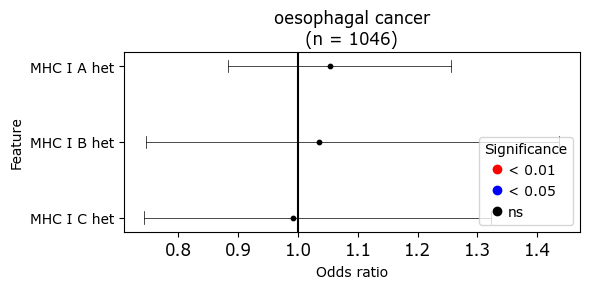

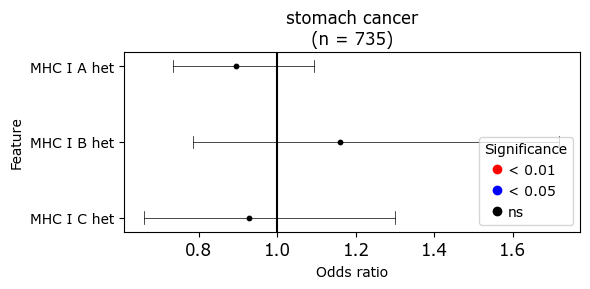

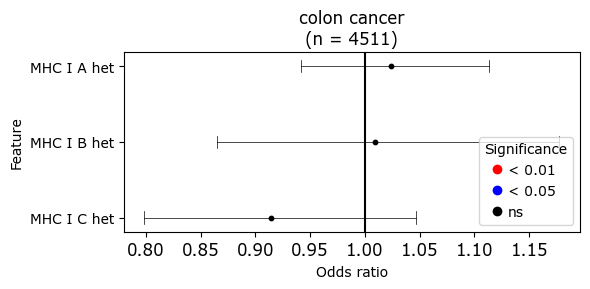

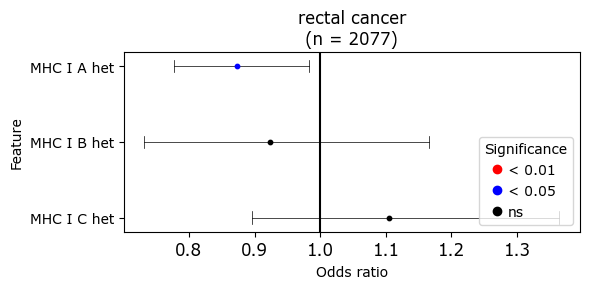

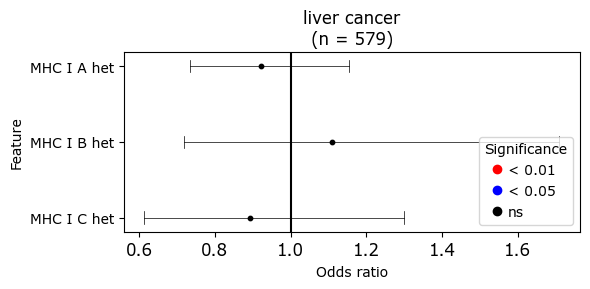

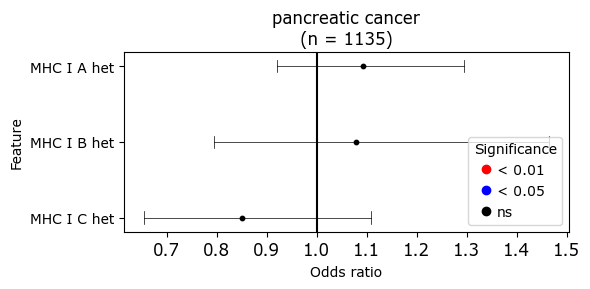

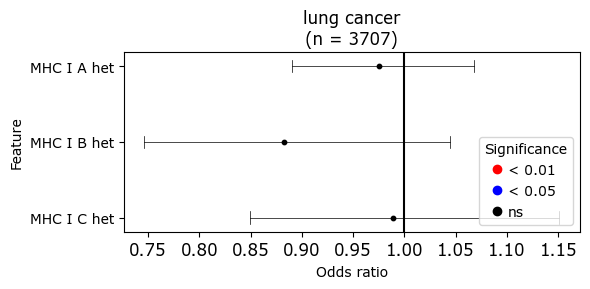

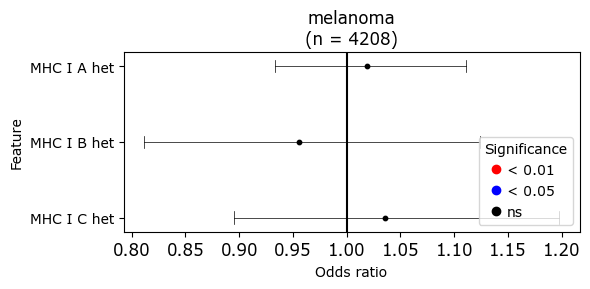

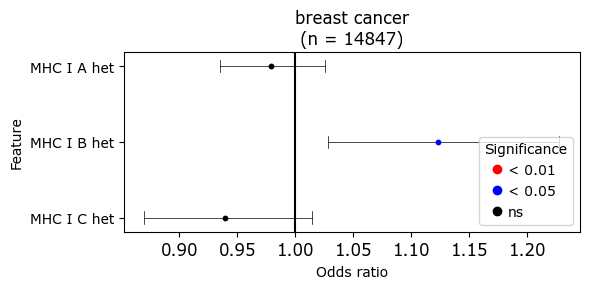

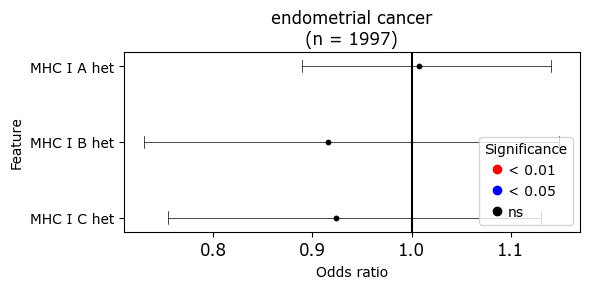

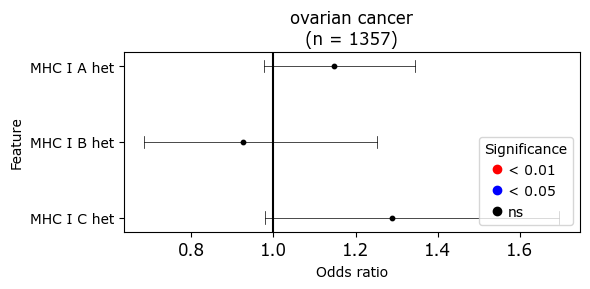

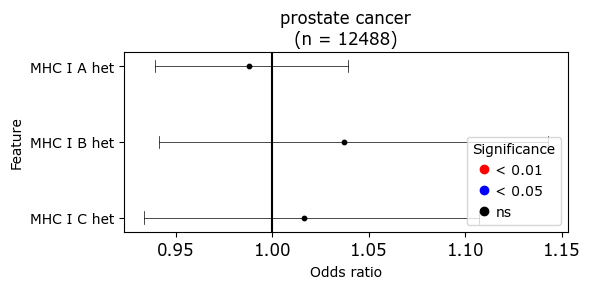

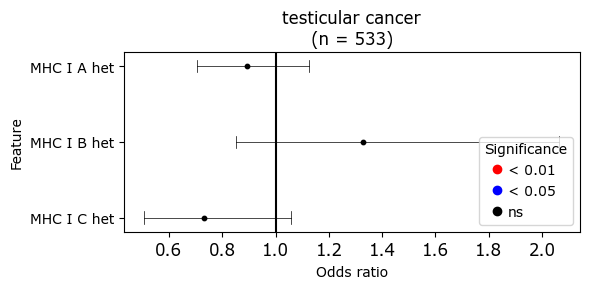

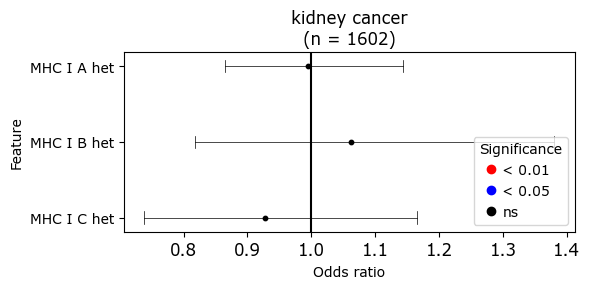

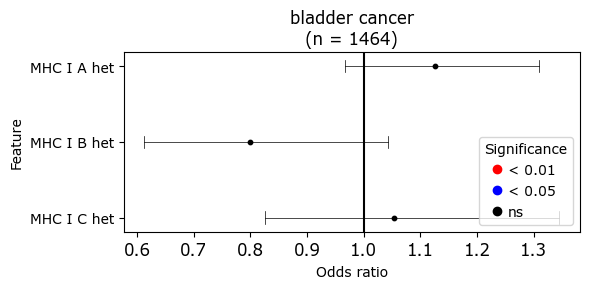

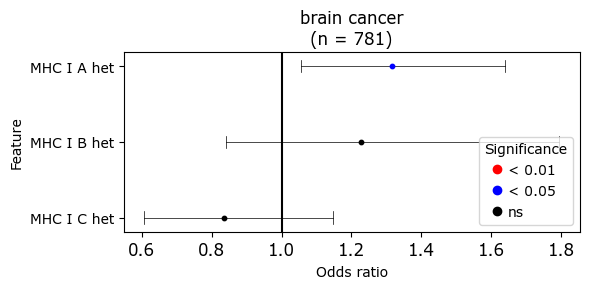

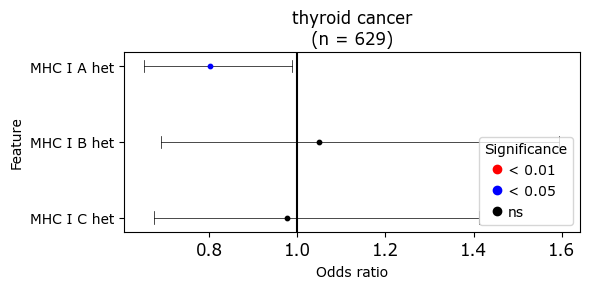

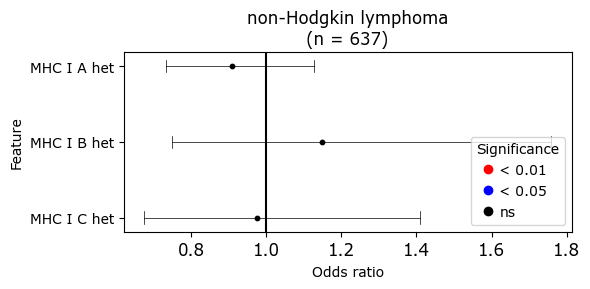

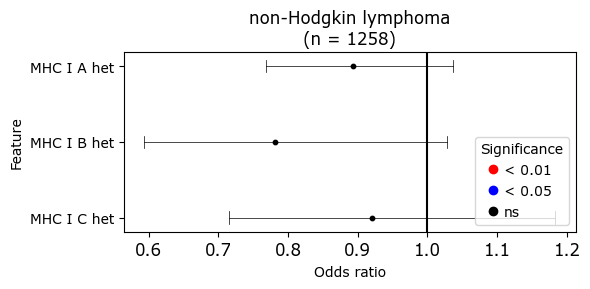

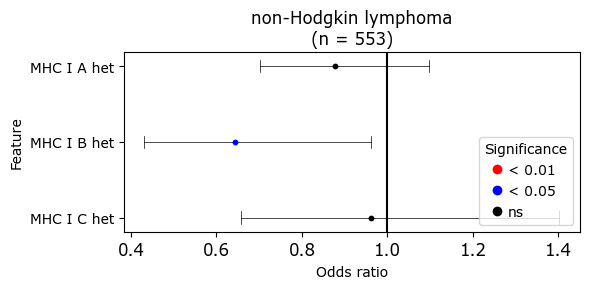

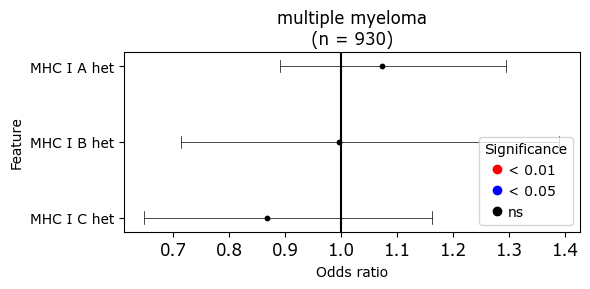

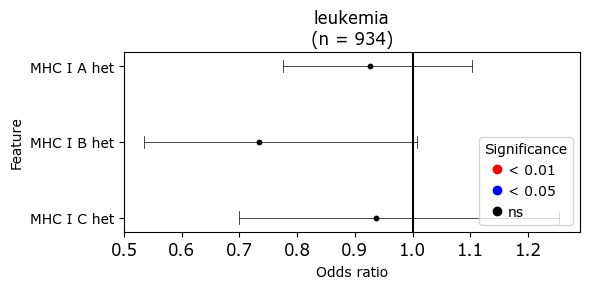

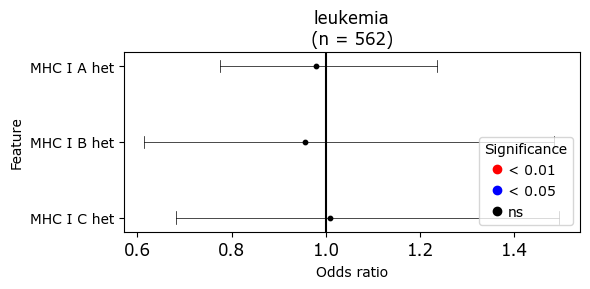

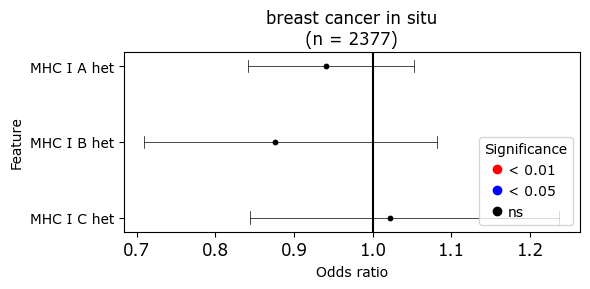

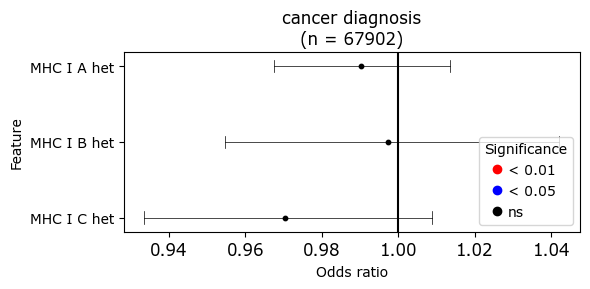

In [32]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['MHC I A het', 'MHC I B het', 'MHC I C het']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()


# MHC class II genotype 

### Prepare the dataset

In [33]:
# okay now it would be good if we could add to this data for NetMHC class II (heterozygosity status)
features_df_hla2 = subset_df2[['Person_ID', 'count_class_II', 'sum_class_II', 'count_class_II_drb', 'het_all_class_II', 
                               'het_allele_II_DRB', 'het_allele_II_DPA', 'het_allele_II_DPB', 'het_allele_II_DQA', 'het_allele_II_DQB',
                               'het_all_class_II_from_allele']]

# add to combined df 
combined_df_clean_mhcii = pd.merge(combined_df_clean, features_df_hla2)

# convert to 0 / 1
combined_df_clean_mhcii['het_allele_II_DRB'] = combined_df_clean_mhcii['het_allele_II_DRB'].astype(int)
combined_df_clean_mhcii['het_allele_II_DPA'] = combined_df_clean_mhcii['het_allele_II_DPA'].astype(int)
combined_df_clean_mhcii['het_allele_II_DPB'] = combined_df_clean_mhcii['het_allele_II_DPB'].astype(int)
combined_df_clean_mhcii['het_allele_II_DQA'] = combined_df_clean_mhcii['het_allele_II_DQA'].astype(int)
combined_df_clean_mhcii['het_allele_II_DQB'] = combined_df_clean_mhcii['het_allele_II_DQB'].astype(int)
combined_df_clean_mhcii['count_class_II_drb'] = combined_df_clean_mhcii['count_class_II_drb'].astype(int)
combined_df_clean_mhcii['het_all_class_II_from_allele'] = combined_df_clean_mhcii['het_all_class_II_from_allele'].astype(int)

# rename columns
combined_df_clean_mhcii.rename(columns = {'het_allele_II_DRB' : 'MHC II DRB1 het', 'het_allele_II_DPA' : 'MHC II DPA het', 'het_allele_II_DPB' : 'MHC II DPB het',
                                    'het_allele_II_DQA' : 'MHC II DQA het', 'het_allele_II_DQB' : 'MHC II DQB het', 'count_class_II_drb' : 'Number of distinct MHC II alleles',
                                    'het_all_class_II_from_allele' : 'MHC II het (10 alleles)'}, inplace = True)


# Plots by feature

In [34]:
# okay we want to look by feature, not by outcome 
# let's run this model as the number is relevant and features are not correlated 

cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
# cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'Number of distinct MHC I alleles', 'Number of distinct MHC II alleles']
    else:
        features = ['Age', 'Ever smoker', 'Number of distinct MHC I alleles', 'Number of distinct MHC II alleles', 'Sex']  
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2647218879.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2647218879.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2647218879.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2647218879.

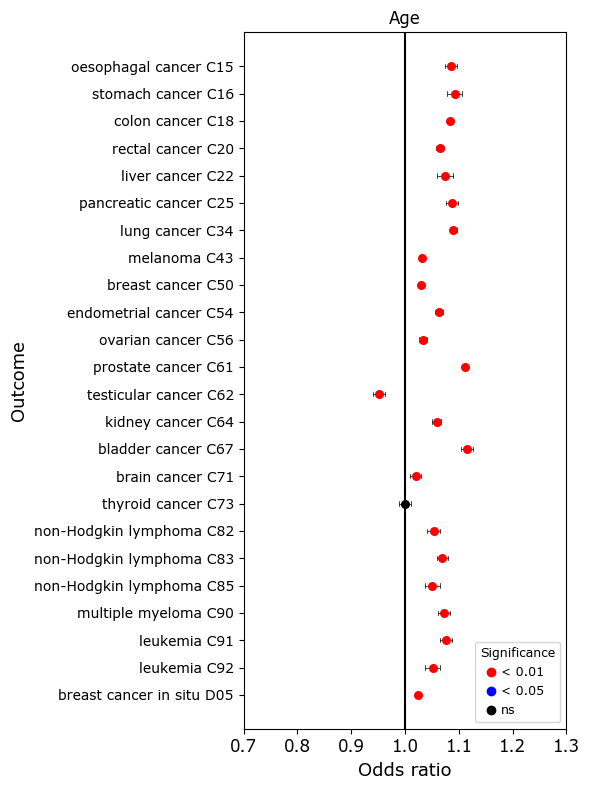

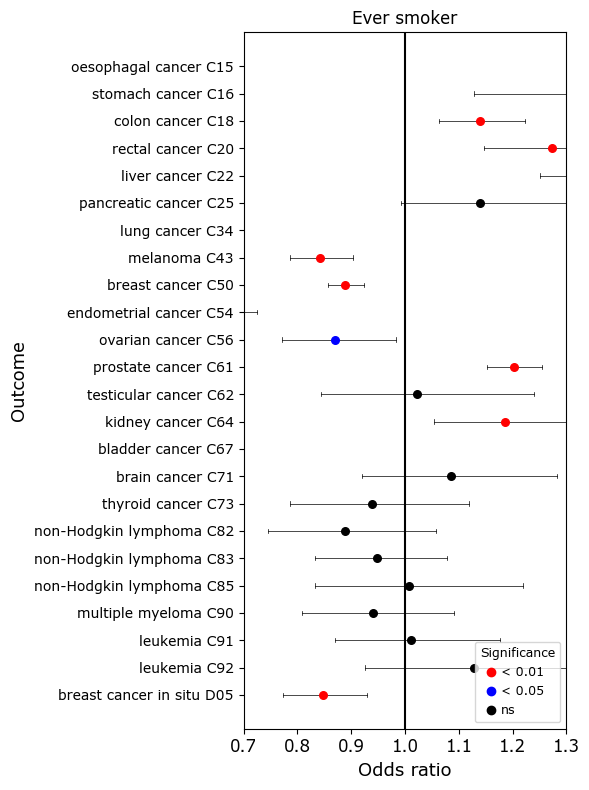

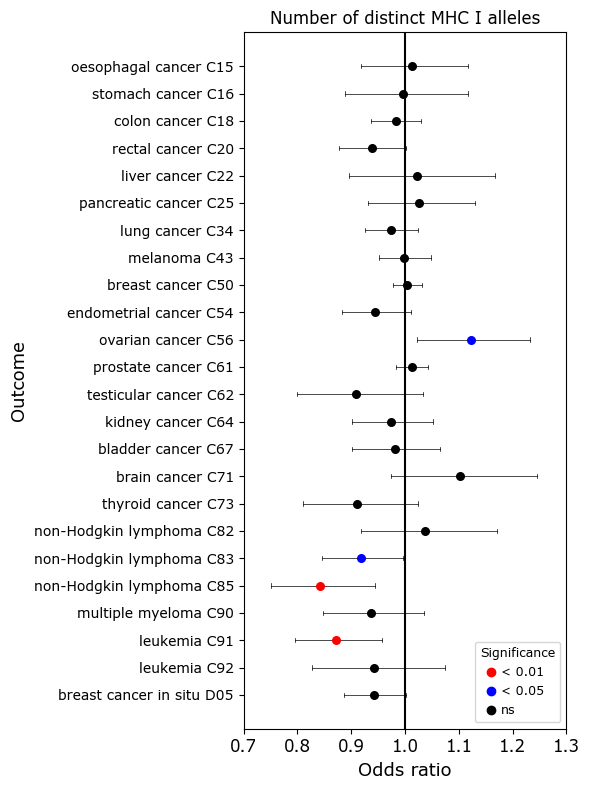

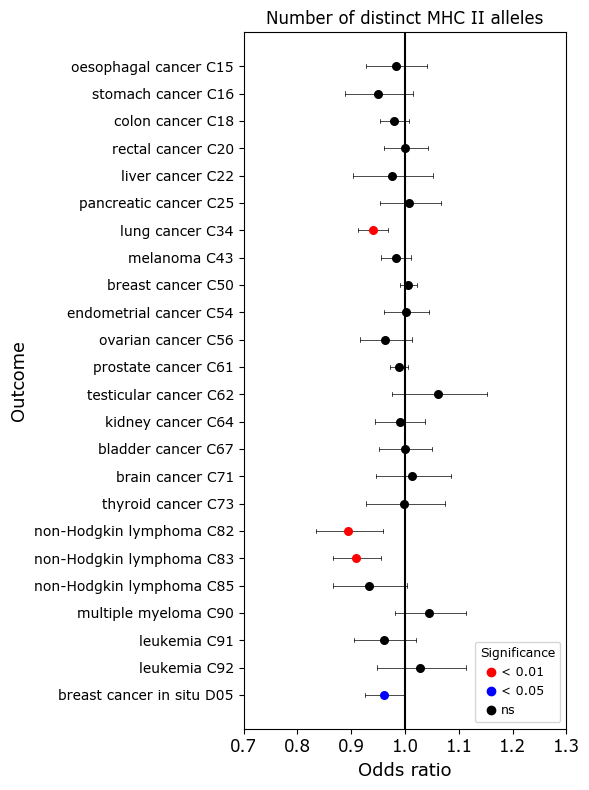

In [35]:

# specify features for which to plot 
features = ['Age', 'Ever smoker', 'Number of distinct MHC I alleles', 'Number of distinct MHC II alleles']

# plot by feature 
for i, feature in enumerate(features):
    
    # separate plot for each feature 
    plt.figure(figsize=(6, 8))
    plt.title(feature)

    descriptors = []
    intercepts = []
    coeffs = []
    lower_confint = []
    upper_confint = []
    coeff_odds_ratios = []
    lower_cis = []
    upper_cis = []
    pvalues_for_outcomes = []
    colors = []

    # identify values for this feature for each outcome 
    for outcome_label, coef_dict in dict_coefficients_mhcii.items():
 
        # identify the outcome (will be on the y axis)
        if outcome_label == 'has_cancer':
            descriptor = 'cancer diagnosis'
        else:
            descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0] + ' ' + outcome_label
        descriptors.append(descriptor)

        # find confidence intervals for the outcome
        # note: the first value is for the intercept so excluding this one 
        confint = dict_confints_mhcii[outcome_label][1:]
        confint = confint.reset_index()

        # specify where to take p values from
        pvalues = dict_pvalues_mhcii[outcome_label][1:]

        # find coefficient values 
        coefficients = dict_coefficients_mhcii[outcome_label][1:]

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        lower_cis.append(lower_ci)
        upper_cis.append(upper_ci)

        pvalue = pvalues[i]
        if pvalues[i] < 0.01: # corresnponds to the number of feature so that works out 
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'

        pvalues_for_outcomes.append(pvalue) 
        colors.append(color)       

    for j, desc in enumerate(descriptors):
        plt.scatter(coeff_odds_ratios[j], desc, alpha = 1, s = 30, color = colors[j], zorder = 2, marker='o')
        plt.plot([lower_cis[j], upper_cis[j]], [desc, desc], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_cis[j], lower_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_cis[j], upper_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')  
    plt.xlabel('Odds ratio', fontsize = 13)
    plt.ylabel('Outcome', fontsize = 13)
    plt.xlim(0.7, 1.3)
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0, fontsize = 9, title_fontsize = 9)

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 11/log_reg_feature_{feature}_mhci_mhcii_nr_alleles_socio_by_feature.pdf', bbox_inches='tight')


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2155038924.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2155038924.py:92: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2155038924.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0]))
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_67989/2155038924.

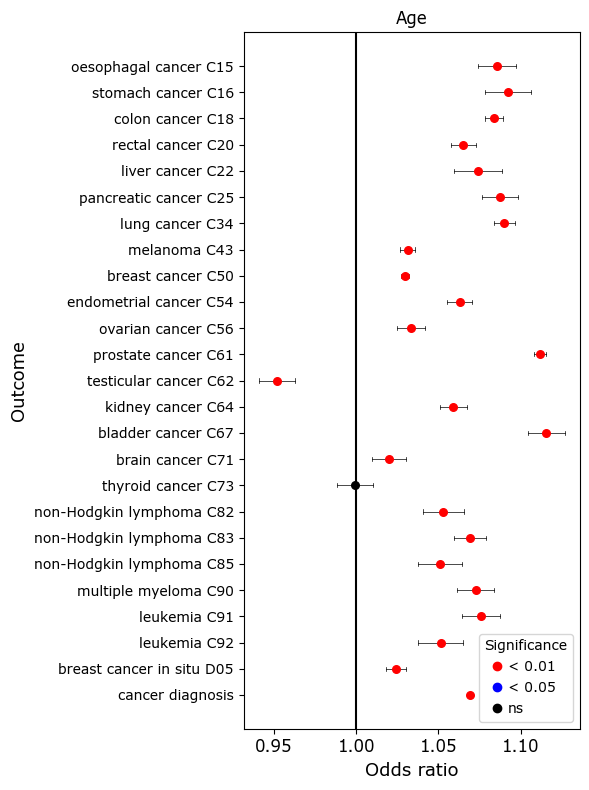

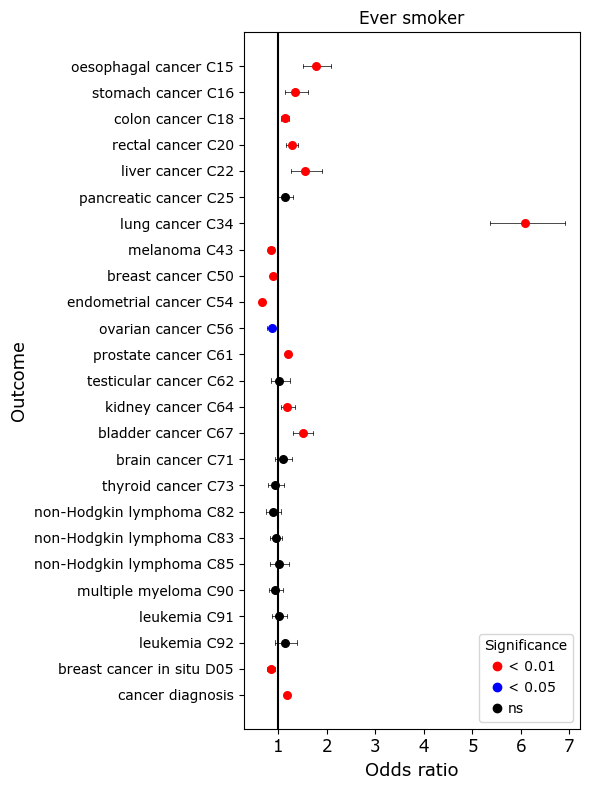

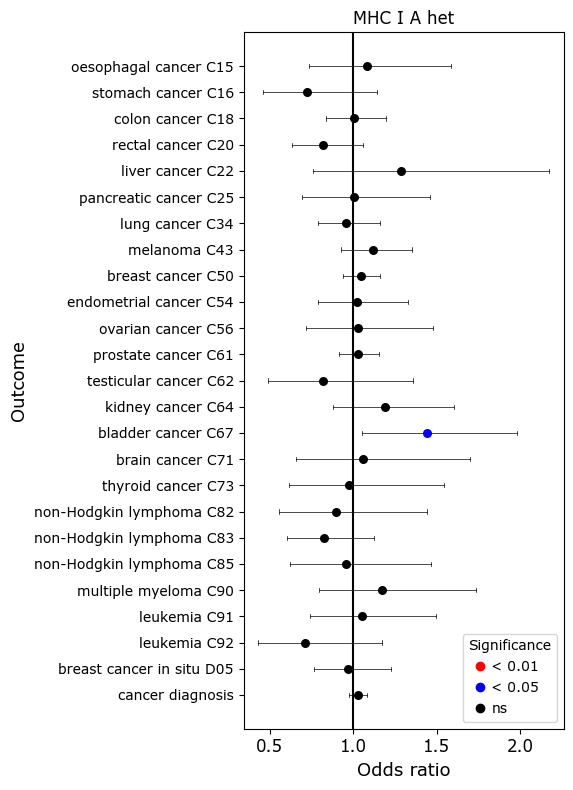

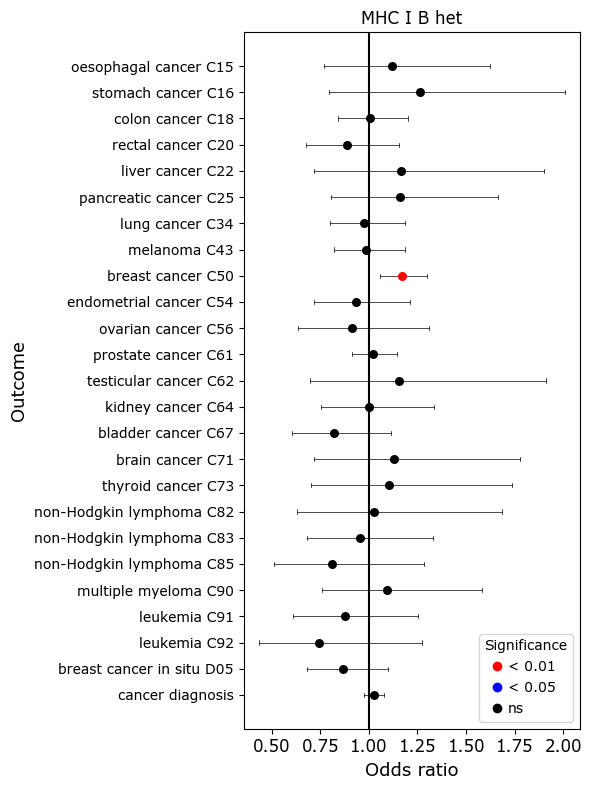

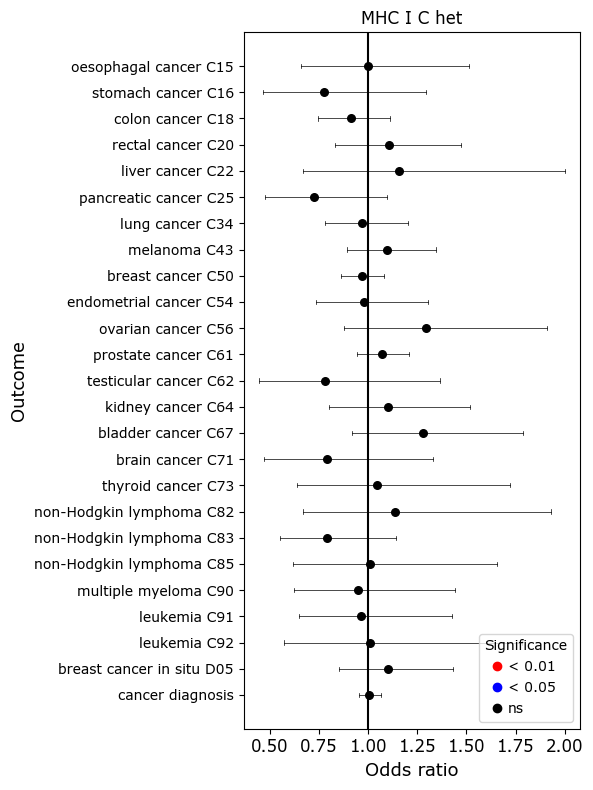

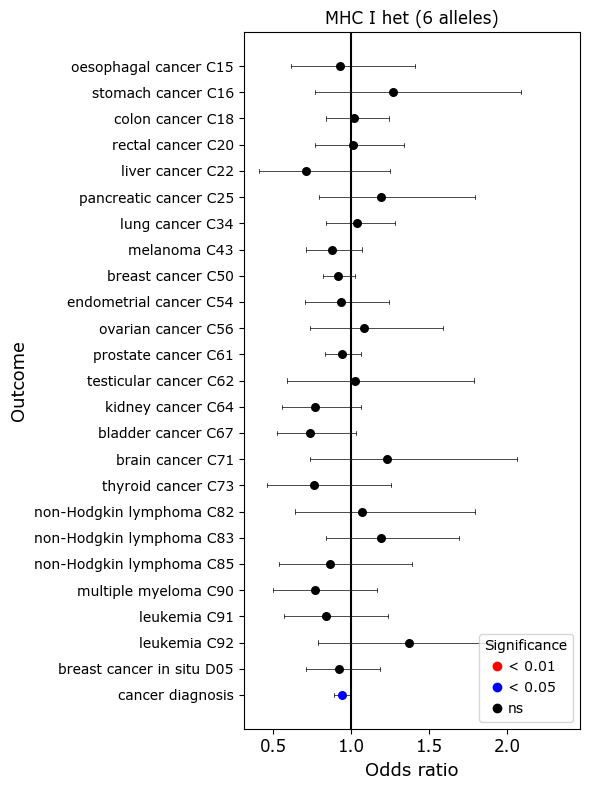

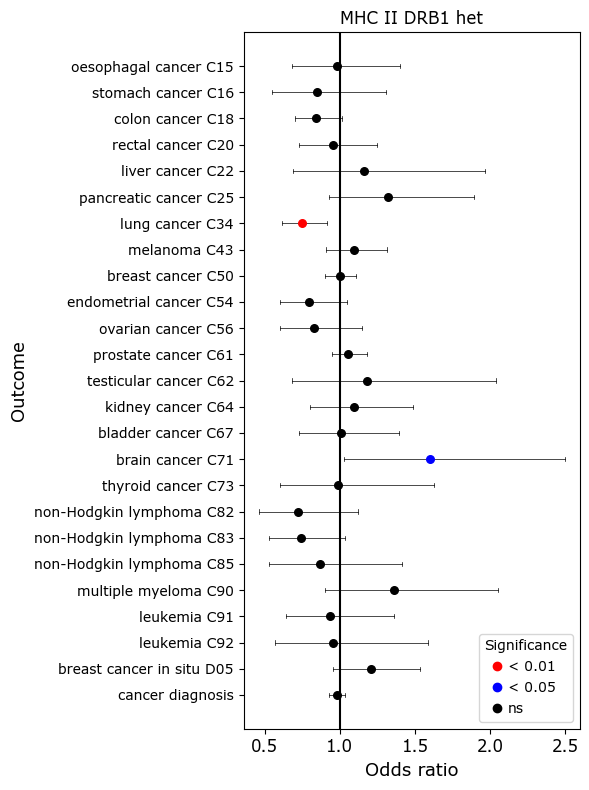

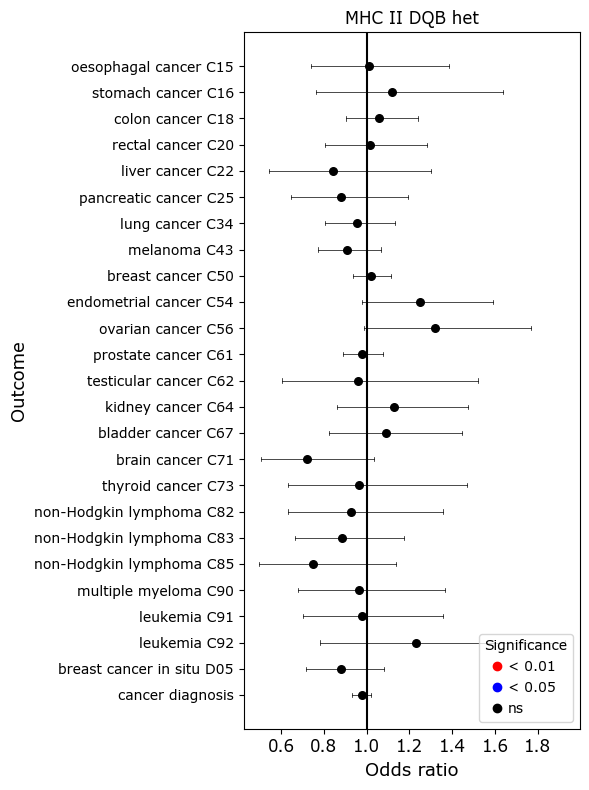

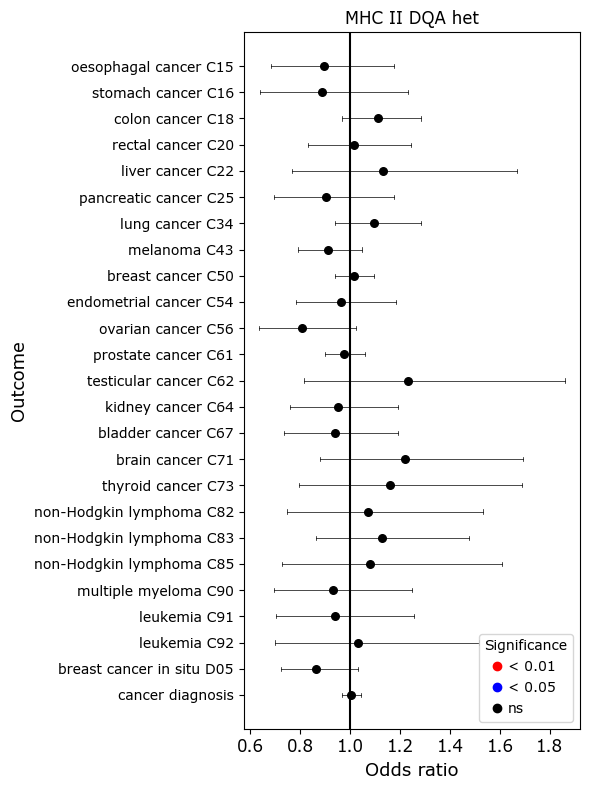

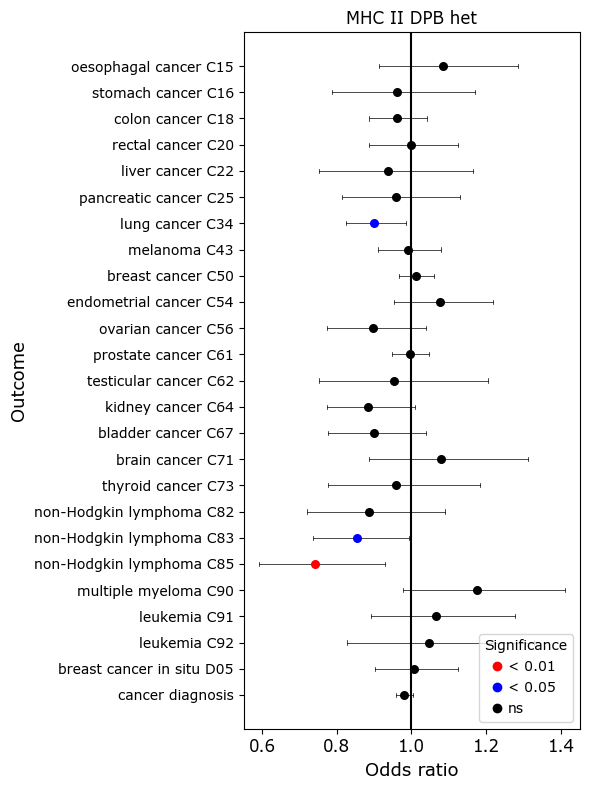

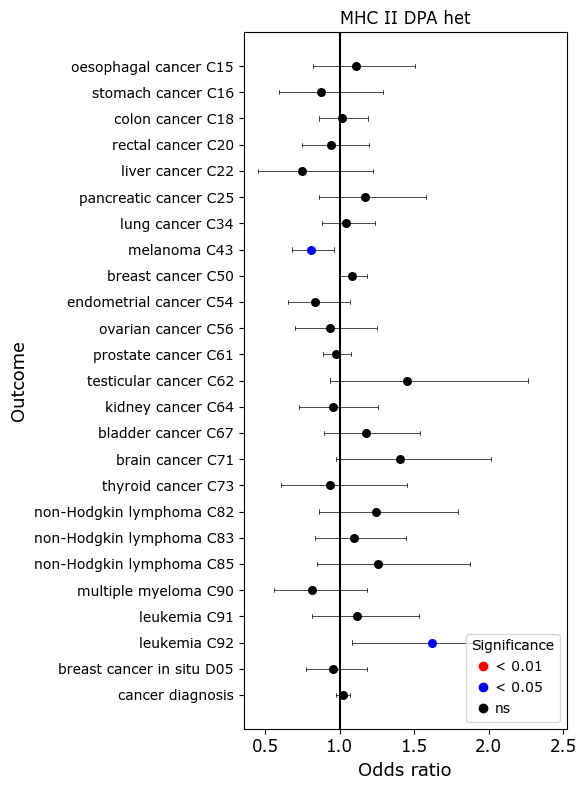

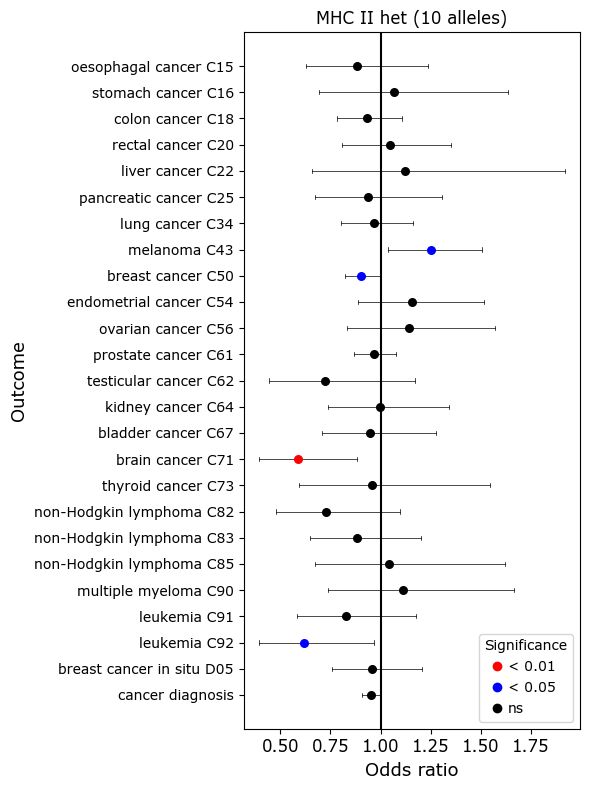

In [36]:
# okay will do this again but now with a different model 
# okay we want to look by feature, not by outcome 
# let's run this model as the number is relevant and features are not correlated 

cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)', 
                    'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)']
    else:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)', 
                    'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)', 'Sex']
        # nb need to include sex as last 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# specify features for which to plot 
features_plot = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)', 
            'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)']

# plot by feature 
for i, feature in enumerate(features_plot):
    
    # separate plot for each feature 
    plt.figure(figsize=(6, 8))
    plt.title(feature)

    descriptors = []
    intercepts = []
    coeffs = []
    lower_confint = []
    upper_confint = []
    coeff_odds_ratios = []
    lower_cis = []
    upper_cis = []
    pvalues_for_outcomes = []
    colors = []

    # identify values for this feature for each outcome 
    for outcome_label, coef_dict in dict_coefficients_mhcii.items():
 
        # identify the outcome (will be on the y axis)
        if outcome_label == 'has_cancer':
            descriptor = 'cancer diagnosis'
        else:
            descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0] + ' ' + outcome_label
        descriptors.append(descriptor)

        # find confidence intervals for the outcome
        # note: the first value is for the intercept so excluding this one 
        confint = dict_confints_mhcii[outcome_label][1:]
        confint = confint.reset_index()

        # specify where to take p values from
        pvalues = dict_pvalues_mhcii[outcome_label][1:]

        # find coefficient values 
        coefficients = dict_coefficients_mhcii[outcome_label][1:]

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        lower_cis.append(lower_ci)
        upper_cis.append(upper_ci)

        pvalue = pvalues[i]
        if pvalues[i] < 0.01: # corresnponds to the number of feature so that works out 
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'

        pvalues_for_outcomes.append(pvalue) 
        colors.append(color)       

    for j, desc in enumerate(descriptors):
        plt.scatter(coeff_odds_ratios[j], desc, alpha = 1, s = 30, color = colors[j], zorder = 2, marker='o')
        plt.plot([lower_cis[j], upper_cis[j]], [desc, desc], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_cis[j], lower_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_cis[j], upper_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')  
    plt.xlabel('Odds ratio', fontsize = 13)
    plt.ylabel('Outcome',fontsize = 13)
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 11/log_reg_feature_{feature}_mhci_mhcii_abc_drpq_het_socio_by_feature.pdf', bbox_inches='tight')
